In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import csv
import sqlite3
import time
import json
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from sklearn import cluster
from sklearn import feature_selection, linear_model
from mpl_toolkits.basemap import Basemap
from geopy.distance import vincenty, great_circle
import statsmodels.formula.api as smf
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (20, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 20
rcParams['patch.edgecolor'] = 'none'

C:\Users\Anirban\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%%time

sample_trips_with_location = pd.read_csv('../nyc_taxi_files/2013_Jan_sample_neighborhood.csv')

Wall time: 8.46 s


In [3]:
sample_trips_with_location.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,tolls_amount,total_amount,pickup_hour,dropoff_hour,tip_fraction,pickup_wday,pickup_day,full_date,month_day,neighborhood
0,F47E83A52C8401C874B99A98CCE246DF,4E260C3310346E735CBDF8C8E6761D66,VTS,1,NaN,2013-01-30 16:34:00,2013-01-30 16:43:00,1,540,0.86,...,0.0,7.5,16,16,0.000000,2,Wednesday,2013-01-30,30,Midtown
1,3AA58DEEC2CA4C104FCA781EC38B6DA1,8F986F92BDA7196564FAA2766EFCD3AD,CMT,1,N,2013-01-16 22:31:15,2013-01-16 22:37:24,1,368,1.20,...,0.0,7.5,22,22,0.000000,2,Wednesday,2013-01-16,16,Noho
2,BEEB829C76993A19098AFA1F5C0C88D2,1C3DFBBA24C7057BF7CB1E48E28153F0,CMT,1,N,2013-01-28 14:34:48,2013-01-28 14:47:36,1,767,1.90,...,0.0,13.2,14,14,0.209524,0,Monday,2013-01-28,28,Clinton
3,3E7AA144EBE43CE6B567524550C78DFF,4AEEA5836012EA84DF0E246D002E1A41,VTS,1,NaN,2013-01-18 18:43:00,2013-01-18 18:50:00,5,420,1.22,...,0.0,10.1,18,18,0.228571,4,Friday,2013-01-18,18,Midtown
4,A5C6F0FC150417517C2894400795B1F8,97336339EBD6E99950B8D11E083E932B,VTS,1,NaN,2013-01-22 00:21:00,2013-01-22 00:37:00,1,960,6.94,...,0.0,22.0,0,0,0.000000,1,Tuesday,2013-01-22,22,Clinton


In [4]:
sample_trips_with_location.columns

Index([u'medallion', u'hack_license', u'vendor_id', u'rate_code',
       u'store_and_fwd_flag', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'trip_time_in_secs', u'trip_distance',
       u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude',
       u'dropoff_latitude', u'payment_type', u'fare_amount', u'surcharge',
       u'mta_tax', u'tip_amount', u'tolls_amount', u'total_amount',
       u'pickup_hour', u'dropoff_hour', u'tip_fraction', u'pickup_wday',
       u'pickup_day', u'full_date', u'month_day', u'neighborhood'],
      dtype='object')

In [5]:
sample_trips_with_location[(sample_trips_with_location['pickup_hour'] == 12) & (sample_trips_with_location['neighborhood'] == 'Midtown')].shape[0]

2765

In [6]:
sample_trips_with_location.groupby(['full_date','neighborhood','pickup_hour']).count().head(10)

medallion  hack_license  vendor_id  \
full_date  neighborhood pickup_hour                                       
2013-01-01 Astoria      0                    2             2          2   
                        1                    6             6          6   
                        2                    7             7          7   
                        3                   10            10         10   
                        4                    7             7          7   
                        5                    4             4          4   
                        6                    3             3          3   
                        9                    4             4          4   
                        10                   2             2          2   
                        11                   1             1          1   

                                     rate_code  store_and_fwd_flag  \
full_date  neighborhood pickup_hour                                  
2013-01-01 Astoria      0                    2                   1   
                        1                    6                   2   
                        2                    7                   2   
                        3                   10                   4   
                        4                    7                   1   
                        5                    4                   1   
                        6                    3                   2   
                        9                    4                   1   
                        10                   2                   0   
                        11                   1                   1   

                                     pickup_datetime  dropoff_datetime  \
full_date  neighborhood pickup_hour                                      
2013-01-01 Astoria      0                          2                 2   
                        1                          6                 6   
                        2                          7                 7   
                        3                         10                10   
                        4                          7                 7   
                        5                          4                 4   
                        6                          3                 3   
                        9                          4                 4   
                        10                         2                 2   
                        11                         1                 1   

                                     passenger_count  trip_time_in_secs  \
full_date  neighborhood pickup_hour                                       
2013-01-01 Astoria      0                          2                  2   
                        1                          6                  6   
                        2                          7                  7   
                        3                         10                 10   
                        4                          7                  7   
                        5                          4                  4   
                        6                          3                  3   
                        9                          4                  4   
                        10                         2                  2   
                        11                         1                  1   

                                     trip_distance    ...      surcharge  \
full_date  neighborhood pickup_hour                   ...                  
2013-01-01 Astoria      0                        2    ...              2   
                        1                        6    ...              6   
                        2                        7    ...              7   
                        3                       10    ...             10   
                        4                        

In [7]:
trip_count_df = pd.DataFrame(columns = ['full_date','pickup_hour','pickup_day','neighborhood','month_day','no_of_trips'])

# All columns except the number of trips are assigned using the .first() corresponding to that column in a particular group
trip_count_df['full_date'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['full_date'].first().values
trip_count_df['pickup_hour'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['pickup_hour'].first().values
trip_count_df['neighborhood'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['neighborhood'].first().values
trip_count_df['pickup_day'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['pickup_day'].first().values
trip_count_df['month_day'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['month_day'].first().values

# The number of trips is determined using the .count() method
trip_count_df['no_of_trips'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['neighborhood'].count().values

In [8]:
trip_count_df.head()

,full_date,pickup_hour,pickup_day,neighborhood,month_day,no_of_trips
0,2013-01-01,0,Tuesday,Astoria,1,2
1,2013-01-01,0,Tuesday,Battery Park City,1,6
2,2013-01-01,0,Tuesday,Bushwick,1,1
3,2013-01-01,0,Tuesday,Carnegie Hill,1,31
4,2013-01-01,0,Tuesday,Central Harlem,1,1


In [9]:
trip_count_df.dtypes

full_date       object
pickup_hour      int64
pickup_day      object
neighborhood    object
month_day        int64
no_of_trips      int64
dtype: object

In [10]:
trip_count_df['date_time'] = trip_count_df['full_date'].astype(str) + ' ' + trip_count_df['pickup_hour'].astype(str)

In [11]:
trip_count_df['date_time'] = trip_count_df['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H'))

In [12]:
trip_count_df.head()

,full_date,pickup_hour,pickup_day,neighborhood,month_day,no_of_trips,date_time
0,2013-01-01,0,Tuesday,Astoria,1,2,2013-01-01
1,2013-01-01,0,Tuesday,Battery Park City,1,6,2013-01-01
2,2013-01-01,0,Tuesday,Bushwick,1,1,2013-01-01
3,2013-01-01,0,Tuesday,Carnegie Hill,1,31,2013-01-01
4,2013-01-01,0,Tuesday,Central Harlem,1,1,2013-01-01


In [13]:
trip_count_df.tail()

,full_date,pickup_hour,pickup_day,neighborhood,month_day,no_of_trips,date_time
29548,2013-01-31,23,Thursday,Turtle Bay,31,49,2013-01-31 23:00:00
29549,2013-01-31,23,Thursday,Upper East Side,31,13,2013-01-31 23:00:00
29550,2013-01-31,23,Thursday,Upper West Side,31,29,2013-01-31 23:00:00
29551,2013-01-31,23,Thursday,West Village,31,28,2013-01-31 23:00:00
29552,2013-01-31,23,Thursday,Yorkville,31,10,2013-01-31 23:00:00


In [14]:
trip_count_df.dtypes

full_date               object
pickup_hour              int64
pickup_day              object
neighborhood            object
month_day                int64
no_of_trips              int64
date_time       datetime64[ns]
dtype: object

In [83]:
timeseries_midtown = trip_count_df[trip_count_df['neighborhood'] == 'Midtown']

In [80]:
timeseries_midtown.head()

,full_date,pickup_hour,pickup_day,neighborhood,month_day,no_of_trips,date_time
26,2013-01-01,0,Tuesday,Midtown,1,56,2013-01-01 00:00:00
74,2013-01-01,1,Tuesday,Midtown,1,19,2013-01-01 01:00:00
127,2013-01-01,2,Tuesday,Midtown,1,34,2013-01-01 02:00:00
182,2013-01-01,3,Tuesday,Midtown,1,39,2013-01-01 03:00:00
237,2013-01-01,4,Tuesday,Midtown,1,23,2013-01-01 04:00:00


In [84]:
timeseries_midtown = timeseries_midtown.reset_index(drop = True)
timeseries_midtown.head()

,full_date,pickup_hour,pickup_day,neighborhood,month_day,no_of_trips,date_time
0,2013-01-01,0,Tuesday,Midtown,1,56,2013-01-01 00:00:00
1,2013-01-01,1,Tuesday,Midtown,1,19,2013-01-01 01:00:00
2,2013-01-01,2,Tuesday,Midtown,1,34,2013-01-01 02:00:00
3,2013-01-01,3,Tuesday,Midtown,1,39,2013-01-01 03:00:00
4,2013-01-01,4,Tuesday,Midtown,1,23,2013-01-01 04:00:00


In [109]:
timeseries_midtown.set_index('date_time', inplace=True)
timeseries_midtown.head()

,full_date,pickup_hour,pickup_day,neighborhood,month_day,no_of_trips
date_time,,,,,,
2013-01-01 00:00:00,2013-01-01,0,Tuesday,Midtown,1,56
2013-01-01 01:00:00,2013-01-01,1,Tuesday,Midtown,1,19
2013-01-01 02:00:00,2013-01-01,2,Tuesday,Midtown,1,34
2013-01-01 03:00:00,2013-01-01,3,Tuesday,Midtown,1,39
2013-01-01 04:00:00,2013-01-01,4,Tuesday,Midtown,1,23


In [110]:
series1=timeseries_midtown['no_of_trips']
series1.head()

date_time
2013-01-01 00:00:00    56
2013-01-01 01:00:00    19
2013-01-01 02:00:00    34
2013-01-01 03:00:00    39
2013-01-01 04:00:00    23
Name: no_of_trips, dtype: int64

In [19]:
from luminol import anomaly_detector

In [88]:
# detector = anomaly_detector.AnomalyDetector(series1)
# anomalies = detector.get_anomalies()

In [111]:
timeseries_midtown.index[48] - timeseries_midtown.index[0]

Timedelta('2 days 00:00:00')

In [119]:
from datetime import timedelta
timeseries_midtown.index[0] + timedelta(days = 2, hours = 1)

Timestamp('2013-01-03 01:00:00')

In [108]:
timeseries_midtown.columns

Index([u'full_date', u'pickup_hour', u'pickup_day', u'neighborhood',
       u'month_day', u'no_of_trips', u'date_time'],
      dtype='object')

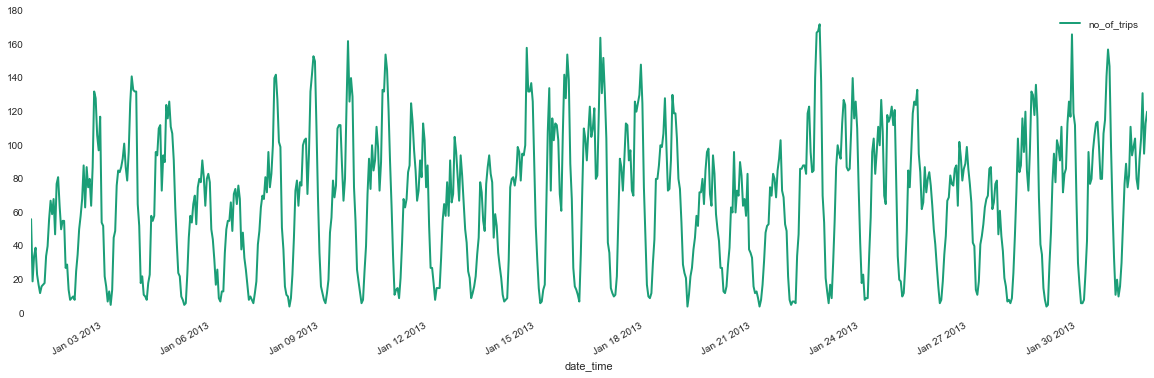

In [120]:
# timeseries_midtown[(timeseries_midtown.index >= '2013-01-01 00:00:00') & (timeseries_midtown.index <= '2013-01-15 00:00:00')][['no_of_trips']].plot()
timeseries_midtown[['no_of_trips']].plot()

In [128]:
print('Autocorrelation daily: ', timeseries_midtown['no_of_trips'].autocorr(24))
print('Autocorrelation weekly: ', timeseries_midtown['no_of_trips'].autocorr(168))
print('Autocorrelation half_day: ', timeseries_midtown['no_of_trips'].autocorr(12))

('Autocorrelation daily: ', 0.79900662949997714)
('Autocorrelation weekly: ', 0.85688319564802495)
('Autocorrelation half_day: ', -0.31508648784349985)


,Lag,Autocorrelation
0,1,0.875299
1,2,0.707558
2,3,0.508735
3,4,0.297564
4,5,0.098172


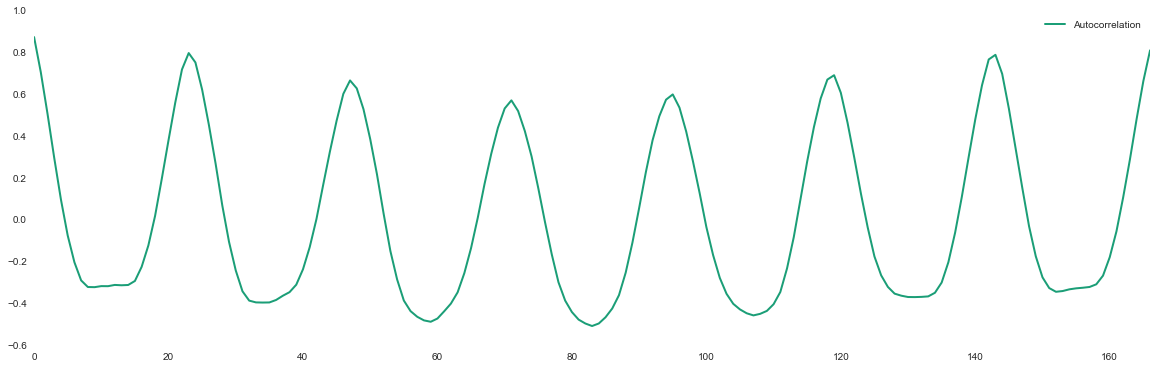

In [129]:
corr_list = []
for lag in range(1, 168):
    corr_list.append(timeseries_midtown['no_of_trips'].autocorr(lag))
corr_list_df = pd.DataFrame(data=corr_list, columns=['Autocorrelation'])
corr_list_df.plot()

def grid_search_corr(x, lag_limit):
    corr_list_dict = pd.DataFrame()
    for lag in range(1, 168):
        corr = x.autocorr(lag)
        if corr > lag_limit:
            corr_list_dict = corr_list_dict.append(pd.DataFrame(data=[[lag, corr]], columns = ['Lag','Autocorrelation']))      
    
    corr_list_dict.index = range(corr_list_dict.shape[0])
    return corr_list_dict

corr_list_df = grid_search_corr(timeseries_midtown['no_of_trips'], -0.6)
corr_list_df.head()

In [95]:
corr_list_df.sort(columns = 'Autocorrelation', ascending = False).head()

C:\Users\Anirban\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Lag,Autocorrelation
0,1,0.875299
166,167,0.812059
23,24,0.799007
143,144,0.790621
142,143,0.768469


In [123]:
n = len(timeseries_midtown['no_of_trips'])

train = timeseries_midtown['no_of_trips'][:int(.8*n)]
# train = timeseries_midtown['no_of_trips'].head(599)
test = timeseries_midtown['no_of_trips'][int(.8*n):]
train = train.apply(float)
test = test.apply(float)

In [124]:
train.tail()

date_time
2013-01-25 14:00:00    133.0
2013-01-25 15:00:00     95.0
2013-01-25 16:00:00     84.0
2013-01-25 17:00:00     62.0
2013-01-25 18:00:00     66.0
Name: no_of_trips, dtype: float64

In [125]:
train.shape

(594L,)

In [126]:
model = sm.tsa.ARIMA(train, order=(2, 0, 2)).fit()

predictions = model.predict(
    '2013-01-24 17:00:00',
    '2013-01-25 18:00:00',
    dynamic=True, 
)

# predictions = model.predict(
#     1, 25,
#     dynamic=True, 
# )

# print("Mean absolute error: ", mean_absolute_error(test, predictions))

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            no_of_trips   No. Observations:                  594
Model:                     ARMA(2, 2)   Log Likelihood               -2558.616
Method:                       css-mle   S.D. of innovations             17.937
Date:                Sun, 25 Sep 2016   AIC                           5129.231
Time:                        22:31:29   BIC                           5155.553
Sample:                    01-01-2013   HQIC                          5139.482
                         - 01-25-2013                                         
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                66.8296      2.424     27.573      0.000        62.079    71.580
ar.L1.no_of_trips     1.7537      0.037     47.804      0.000         1.682     1.826
ar.L2.no_of_trips    -0.8336      0.031    -26.740      0.000        -0.895    -0.773
ma.L1.no_of_trips    -0.7585      0.055    -13.754      0.000        -0.867    -0.650
ma.L2.no_of_trips     0.0208      0.047      0.442      0.658        -0.071     0.113
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0519           -0.3052j            1.0953           -0.0449
AR.2            1.0519           +0.3052j            1.0953            0.0449
MA.1            1.3699           +0.0000j            1.3699            0.0000
MA.2           35.1259           +0.0000j           35.1259            0.0000
-----------------------------------------------------------------------------
"""

In [127]:
predictions

date_time
2013-01-24 17:00:00    59.549243
2013-01-24 18:00:00    50.823448
2013-01-24 19:00:00    44.827981
2013-01-24 20:00:00    41.587450
2013-01-24 21:00:00    40.902317
2013-01-24 22:00:00    42.402131
2013-01-24 23:00:00    45.603553
2013-01-25 00:00:00    49.967749
2013-01-25 01:00:00    54.952660
2013-01-25 02:00:00    60.056838
2013-01-25 03:00:00    64.852739
2013-01-25 04:00:00    69.008582
2013-01-25 05:00:00    72.298913
2013-01-25 06:00:00    74.604921
2013-01-25 07:00:00    75.906189
2013-01-25 08:00:00    76.265951
2013-01-25 09:00:00    75.812120
2013-01-25 10:00:00    74.716316
2013-01-25 11:00:00    73.172881
2013-01-25 12:00:00    71.379576
2013-01-25 13:00:00    69.521215
2013-01-25 14:00:00    67.757061
2013-01-25 15:00:00    66.212351
2013-01-25 16:00:00    64.973958
2013-01-25 17:00:00    64.089833
2013-01-25 18:00:00    63.571651
dtype: float64

In [56]:
lloyd = {
    "name": "Lloyd",
    "homework": [90.0, 97.0, 75.0, 92.0],
    "quizzes": [88.0, 40.0, 94.0],
    "tests": [75.0, 90.0]
}
alice = {
    "name": "Alice",
    "homework": [100.0, 92.0, 98.0, 100.0],
    "quizzes": [82.0, 83.0, 91.0],
    "tests": [89.0, 97.0]
}
tyler = {
    "name": "Tyler",
    "homework": [0.0, 87.0, 75.0, 22.0],
    "quizzes": [0.0, 75.0, 78.0],
    "tests": [100.0, 100.0]
}

students = [lloyd, alice, tyler]

In [67]:
for student in students:
    print student["name"]
    print student["homework"]
    print student["quizzes"]
    print student["tests"]

Lloyd
354.0
[88.0, 40.0, 94.0]
[75.0, 90.0]
Alice
390.0
[82.0, 83.0, 91.0]
[89.0, 97.0]
Tyler
184.0
[0.0, 75.0, 78.0]
[100.0, 100.0]


In [77]:
def get_average(score):
    total = sum(score)
    num = len(score)
    average = total/num
    return average

# for student in students:
print lloyd['name']
print get_average(lloyd['tests'])
print get_average(lloyd['homework'])
print get_average(lloyd['quizzes'])

Lloyd
82.5
88.5
74.0
